I'm going to be doing some data sonification/visualization on wildfire data from 1992-2015 from the wildfire dataset found on Kaggle 

### Data Fields that I will be using with their descriptions. 
#### Data set was obtained from Kaggle and can be found here: https://www.kaggle.com/rtatman/188-million-us-wildfires
<li>LATITUDE = Latitude (NAD83) for point location of the fire (decimal degrees).
<li>LONGITUDE = Longitude (NAD83) for point location of the fire (decimal degrees).
<li>FIRE_SIZE_CLASS = Code for fire size based on the number of acres within the final fire perimeter expenditures (A=greater than 0 but less than or equal to 0.25 acres, B=0.26-9.9 acres, C=10.0-99.9 acres, D=100-299       acres, E=300 to 999 acres, F=1000 to 4999 acres, and G=5000+ acres).
<li>DISCOVERY_DATE = Date on which the fire was discovered or confirmed to exist.
<li>DISCOVERY_TIME = Time of day that the fire was discovered or confirmed to exist.
<li>FIRE_SIZE = Estimate of acres within the final perimeter of the fire.

In [1]:
%matplotlib inline
import sqlite3
import pandas as pd
from miditime.miditime import MIDITime
import datetime
import julian as jl
from midiutil.MidiFile3 import MIDIFile
import os
import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import cartopy.feature as cfeature
from mido import MidiFile
import matplotlib.patches as mpatches
from progress.bar import Bar
from matplotlib.animation import FuncAnimation
import matplotlib.cm as cm
import numpy as np
from IPython.display import HTML
import math

In [2]:
'''
Combines the Julian date with the TOD that the event occurred and outputs a datetime
'''
def fix_datetime(jul, hour, minute, second):
    #validate input
    if (int(hour) < 0 or int(hour) > 24):
        print("Hour not between 0 and 24 inclusive")
        return
    if (int(minute) < 0 or int(minute) > 60):
        print("Minute not between 0 and 60 inclusive")
        return
    if (second < 0 or second > 60):
        print("Second not between 0 and 60 inclusive")
        return
    #Get Decimal for time of day.
    dec_time = ((int(hour)*60*60) + (int(minute)*60) + second) / 86400
    jul_str = str(jul)
    flt_jul = float(jul_str) + dec_time
    dt = jl.from_jd(round(flt_jul,2), fmt='jd')
    return dt.replace(microsecond=0)

In [3]:
'''
Used to tune the magnitude of the wildfire to a musical note.
'''
def mag_to_pitch_tuned(magnitude, max_fire, min_fire):
    #Logarithmic scale, reverse order
    scale_pct = mymidi.log_scale_pct(min_fire, max_fire, magnitude, True,direction='log')

    # Pick a range of notes. This allows you to play in a key.
    c_major = ['C', 'D', 'E', 'F', 'G', 'A', 'B']

    #Find the note that matches your data point
    note = mymidi.scale_to_note_classic(scale_pct, c_major)

    #Translate that note to a MIDI pitch
    midi_pitch = mymidi.note_to_midi_pitch(note)

    return midi_pitch

In [4]:
'''
Creates and saves the midi file.
'''
def create_midi(note_list):
    track    = 0
    channel  = 0
    time     = 0              # In beats
    tempo    = mymidi.tempo   # In BPM
    MyMIDI = MIDIFile(1)      # One track Midifile.
    MyMIDI.addTempo(track, time, tempo)

    #Add Notes
    for n in note_list:
        MyMIDI.addNote(track, channel, n[1], n[0], n[3], n[2])

    #Save to MIDI file.
    with open(mymidi.outfile, "wb") as output_file:
        MyMIDI.writeFile(output_file)

In [5]:
#State we want to gather data from
fire_state = 'MT'
boundary_box = [-116.5, -103, 44, 49.5] #long/lat boundary for MT.

#First year to start gathering wildfire data from
fire_year_start = 1992
#Last year to gather wildfire data from
fire_year_end = 2015

#Minimum Fire size
min_fire_size = 0.0

#SQL where conditional string
sql_where_clause = "where STATE = '{0}' and FIRE_YEAR >= {1} and FIRE_YEAR <= {2} and FIRE_SIZE >= {3}".format(fire_state, fire_year_start, fire_year_end, min_fire_size)

#Midi Variables
midi_tempo = 120
midi_filename = "Audio/wildfire_sonification.mid"
midi_seconds_per_year = 12
midi_starting_octave = 1
midi_octave_range = 7

#Video Variables
frames_per_second = 30
fig_width = 12.8
fig_height = 7.2
dots_per_inch = 100

### Obtain and Clean Dataset

In [6]:
%%capture
#Get Data out of database file.
cnx = sqlite3.connect("{0}/FPA_FOD_20170508.sqlite".format(os.getcwd()))
df_sonify = pd.read_sql_query("select DISCOVERY_DATE, DISCOVERY_TIME, FIRE_SIZE, FIRE_SIZE_CLASS, \
                              LATITUDE, LONGITUDE FROM 'Fires' {0} order by DISCOVERY_DATE asc".format(sql_where_clause), cnx)
df_sonify.dropna()

#Get min and max values of FIRE_SIZE for logarithmic scale and tuning of fire size/notes.
c = cnx.cursor()
c.execute("select MAX(FIRE_SIZE) FROM 'Fires' {}".format(sql_where_clause))
max_fire = c.fetchone()[0]
min_fire = min_fire_size

#Fix and combine the date
for index, row in df_sonify.iterrows():
    if (str(row['DISCOVERY_DATE']).lower() == 'none' or str(row['DISCOVERY_TIME']).lower() == 'none'):
        df_sonify.drop(index, inplace=True)
    else:
        df_sonify.loc[index, 'DISCOVERY_DATE'] = fix_datetime(row["DISCOVERY_DATE"], 
                                                              row["DISCOVERY_TIME"][0:2], row["DISCOVERY_TIME"][2:], 00)


#Sort records by DISCOVERY_DATE
df_sonify = df_sonify.sort_values(by=['DISCOVERY_DATE'])
df_sonify = df_sonify.reset_index(drop=True)

'''
Create MIDITime object.
https://github.com/cirlabs/miditime
(Tempo, Filename, Seconds per year, Starting Octave, Octave Range, Start of Epoch Date)
'''
mymidi = MIDITime(midi_tempo, midi_filename, midi_seconds_per_year, midi_starting_octave, 
                  midi_octave_range, df_sonify.iloc[0]['DISCOVERY_DATE'])

#Create new column that contains the number of days since the start of the epoch
for index, row in df_sonify.iterrows():
    df_sonify.loc[index, 'DAYS_SINCE_EPOCH'] = mymidi.days_since_epoch(row['DISCOVERY_DATE'])

#Convert DAYS_SINCE_EPOCH to a BEAT to be used in the MIDI file output.
for index, row in df_sonify.iterrows():
    df_sonify.loc[index, 'BEAT'] = mymidi.beat(row['DAYS_SINCE_EPOCH'])

#Tune the fire size value to fit a musical note. 
for index, row in df_sonify.iterrows():
    df_sonify.loc[index, 'SCALED_FIRE_SIZE'] = mag_to_pitch_tuned(row['FIRE_SIZE'], max_fire, min_fire)

In [7]:
df_sonify.head()

,DISCOVERY_DATE,DISCOVERY_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,DAYS_SINCE_EPOCH,BEAT,SCALED_FIRE_SIZE
0,1992-01-04 21:07:11,2100,1.3,B,48.3167,-109.8341,0.000000,0.00,81.0
1,1992-01-06 07:11:59,0710,2.0,B,48.1150,-105.1650,1.420000,0.09,79.0
2,1992-01-08 23:31:11,2330,91.0,C,48.0833,-108.3674,4.100000,0.27,57.0
3,1992-01-09 00:00:00,2355,4.0,B,48.0000,-108.5674,4.120012,0.27,74.0
4,1992-01-09 19:26:24,1921,0.2,A,48.2667,-109.7841,4.930012,0.32,91.0


### Generate MIDI file

In [8]:
#Generate Note List
start_time = df_sonify['BEAT'][0]
note_list = []
for index, row in df_sonify.iterrows():
    note_list.append([
        row['BEAT'] - start_time,
        int(row['SCALED_FIRE_SIZE']),
        100,  # velocity
        1  # duration, in beats
    ])

#Create MIDI file
create_midi(note_list)

### Convert MIDI to WAV File
I have a Mac and found most of the python options for converting midi to wav to be a bit cumbersome. The easiest method I found was through Timidity. <br/>
Run the following commands:<br/>

<li> brew install timidity 
<li> timidity Audio/wildfire_sonification.mid -Ow -o Audio/wildfire_audio.wav
<br/><br/>
    
Ta-Da!  
Now we have our wav file. 

### Generate Animation Frames

Map tiles by <a href="http://stamen.com">Stamen Design</a>, under <a href="http://creativecommons.org/licenses/by/3.0">CC BY 3.0</a>. Data by <a href="http://openstreetmap.org">OpenStreetMap</a>, under <a href="http://www.openstreetmap.org/copyright">ODbL</a>.

In [9]:
#Create a new dataframe to house the mapping data. 
df_mapping = df_sonify

In [11]:
mid = MidiFile(mymidi.outfile)

#create a new column with number of ticks:
for index, row in df_mapping.iterrows():
    df_mapping.loc[index, 'TICKS'] = row['BEAT'] * mid.ticks_per_beat

#Determine how many milliseconds per tick: 60000 / (BPM * PPQ)
millis_per_tick = 60000.0 / (120 * mid.ticks_per_beat)

#create a new column with time elapsed in milliseconds
for index, row in df_mapping.iterrows():
    df_mapping.loc[index, 'MILLIS'] = row['TICKS'] * millis_per_tick
    
#Normalize Fire Size for Plotting using tanh
#https://stackoverflow.com/questions/50310059/normalize-a-column-to-represent-it-as-a-size-in-a-scatter-plot/50311206
for index, row in df_mapping.iterrows():
    df_mapping.loc[index, 'PLOT_SIZE'] = math.tanh(row['FIRE_SIZE']/500-2)*250+250


In [12]:
df_mapping.head()

,DISCOVERY_DATE,DISCOVERY_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,DAYS_SINCE_EPOCH,BEAT,SCALED_FIRE_SIZE,TICKS,MILLIS,PLOT_SIZE
0,1992-01-04 21:07:11,2100,1.3,B,48.3167,-109.8341,0.000000,0.00,81.0,0.0,0.0,9.039143
1,1992-01-06 07:11:59,0710,2.0,B,48.1150,-105.1650,1.420000,0.09,79.0,86.4,45.0,9.064029
2,1992-01-08 23:31:11,2330,91.0,C,48.0833,-108.3674,4.100000,0.27,57.0,259.2,135.0,12.840342
3,1992-01-09 00:00:00,2355,4.0,B,48.0000,-108.5674,4.120012,0.27,74.0,259.2,135.0,9.135502
4,1992-01-09 19:26:24,1921,0.2,A,48.2667,-109.7841,4.930012,0.32,91.0,307.2,160.0,9.000173


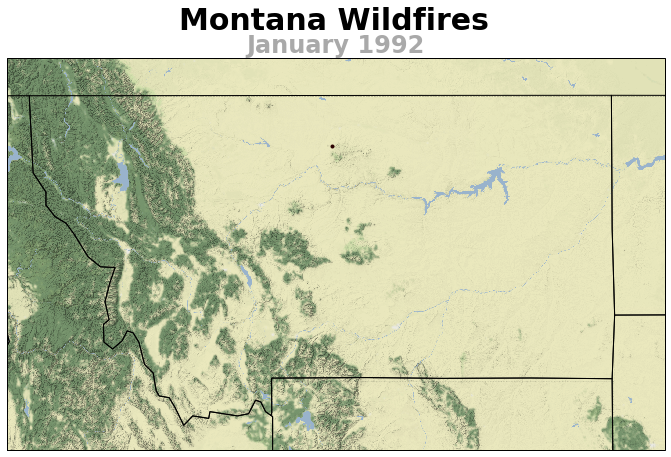

In [13]:
#determine how many milliseconds to cycle thru for each frame
millis_per_frame = 1000 / frames_per_second

#print total frames to be output
total_frames = round((df_mapping['MILLIS'].max() + millis_per_frame) / millis_per_frame)

#set current plot data frame index = 0
df_index = 0

#Set up figure and axes with cartopy data.
map_terrain = cimgt.Stamen('terrain-background')
fig = plt.figure(figsize=(fig_width,fig_height))
ax = plt.axes(projection=map_terrain.crs) #mercator
fig.suptitle('Montana Wildfires', x=0.51, ha='center', va='top', color='black', fontsize=30, fontweight='bold')
ax.set_extent([-116.5, -103, 44, 49.5])
ax.add_image(map_terrain,8,zorder=0)
ax.add_feature(cfeature.STATES, zorder=1)

#initialize data lists
long_vals = []
lat_vals = []
intensity = []
size = []

scatter = ax.scatter(long_vals, lat_vals, c=[], cmap=cm.hot_r, vmin=0, vmax=1, zorder=2, transform=map_terrain.crs.as_geodetic())

#Some of the below was modelled off of the following link: https://stackoverflow.com/questions/48152754/matplotlib-plot-points-over-time-where-old-points-fade
def get_data(milli_count):
    global df_index
        
    #Grab relevant data from pandas dataframe using between.
    current_plots = df_mapping[df_mapping['MILLIS'].between(df_mapping['MILLIS'][df_index], milli_count, inclusive=True)]
    
    lats  = current_plots['LATITUDE'].tolist()
    longs = current_plots['LONGITUDE'].tolist()
    sizes = current_plots['PLOT_SIZE'].tolist()
    
    #update dataframe index (indexes are maintained in sub dataframe from the original dataframe)
    df_index = current_plots.index.max()
    
    return lats, longs, sizes

def update(frame):
    global long_vals, lat_vals, intensity, size
    # Get intermediate coordinates
    new_lats, new_longs, new_sizes = get_data(frame*millis_per_frame)
    
    long_vals.extend(new_longs)
    lat_vals.extend(new_lats)

    # Plot New Values
    scatter.set_offsets(np.c_[long_vals,lat_vals])

    #calculate new color values
    intensity = np.concatenate((np.array(intensity)*0.97, np.full(len(new_longs), 0.95)))#np.ones(len(new_longs))))
    scatter.set_array(intensity)
    
    #calculate new size values
    size = np.concatenate((np.array(size)*0.98, new_sizes))
    scatter.set_sizes(size)
    
    ax.set_title(df_mapping[df_mapping['MILLIS'].between(df_mapping['MILLIS'][df_index], frame*millis_per_frame, inclusive=True)]['DISCOVERY_DATE'].max().strftime('%B %Y'), color='darkgray', fontsize=24, fontweight='bold')
    
    return scatter,

anim = FuncAnimation(fig, update, interval=millis_per_frame, save_count=total_frames, blit=True)

In [14]:
anim.save("Video/animation_wildfire.mp4", writer='ffmpeg', fps=frames_per_second, dpi=dots_per_inch)

### Create mp4 file from .wav and animation.
Utilizing the following ffmpeg command I was able to generate my mp4 file with the sonified wildfire data. This created a visual and audio representation of the data.<br/>
Run the following command:<br/>
    
<li> ffmpeg -i Video/animation_wildfire.mp4 -i Audio/wildfire_audio.wav -map 0:0 -map 1:0 -c:v copy -c:a copy Video/wildfire_final.mov
